**Instituto Tecnológico de Aeronáutica – ITA**

**Visão Computacional - CM-203**

**Professores:** 

Elcio Hideiti Shiguemori

Gabriel Adriano de Melo

Marcos Ricardo Omena de Albuquerque Maximo

**Orientações padrão:**

Antes de você entregar o Lab, tenha certeza de que tudo está rodando corretamente (sequencialmente): Primeiro, **reinicie o kernel** (`Runtime->Restart Runtime` no Colab ou `Kernel->Restart` no Jupyter), depois rode todas as células (`Runtime->Run All` no Colab ou `Cell->Run All` no Jupyter) e verifique que as células rodem sem erros, principalmente as de correção automática que apresentem os `assert`s.

É muito importante que vocês não apaguem as células de resposta para preenchimento, isto é, as que contenham o `ESCREVA SEU CÓDIGO AQUI` ou o "ESCREVA SUA RESPOSTA AQUI", além das células dos `assert`, pois elas contém metadados com o id da célula para os sistemas de correção automatizada e manual. O sistema de correção automatizada executa todo o código do notebook, adicionando testes extras nas células de teste. Não tem problema vocês criarem mais células, mas não apaguem as células de correção. Mantenham a solução dentro do espaço determinado, por organização. Se por acidente acontecer de apagarem alguma célula que deveria ter a resposta, recomendo iniciar de outro notebook (ou dar um `Undo` se possível), pois não adianta recriar a célula porque perdeu o ID.

Os Notebooks foram programados para serem compatíveis com o Google Colab, instalando as dependências necessárias automaticamente a baixando os datasets necessários a cada Lab. Os comandos que se inicial por ! (ponto de exclamação) são de bash e também podem ser executados no terminal linux, que justamente instalam as dependências.

---

# Lab de Processamento de Imagens

Neste laboratório você irá implementar e aplicar algumas transformações simples referentes a etapa de processamento de imagens (Aula 2 do Prof. Élcio), aplicando ao exemplo mostrado em aula de OCR (Optical Character Recognition) para identificar os caracteres de uma placa de contêiner.

In [284]:
# !pip3 install opencv-contrib-python==4.6.0.66 Pillow==7.1.2 matplotlib==3.2.2 scipy==1.7.3 gdown==4.4.0
# tesseract-ocr (4.0.0-2), tesseract-ocr-eng (1:4.00)
def instala_deps():
    """ Instala as dependências e reinicia se necessário """
    try:
        import pytesseract
    except:
        !apt install tesseract-ocr && pip install pytesseract==0.3.10
        if 'google.colab' in str(get_ipython()):
            import os
            os.kill(os.getpid(), 9)

instala_deps()

In [285]:
import cv2
import os
import pytesseract
import numpy as np
import PIL.Image
from pathlib import Path
from matplotlib import pyplot as plt

def ocr(imagem):
    """Retorna a primeira linha de caracteres detectada pelo Tesseract como uma string"""
    return pytesseract.image_to_string(imagem, config='--oem 1 --psm 7').split('\n')[0]

Abaixo realizamos o download das imagens, se estiver executando o notebook localmente (e não no colab), pode baixar o arquivo zip https://drive.google.com/file/d/1x7ZyRx_be-U9u0NM_rSN_3-Wb_srf-5h, extrair e apontar o caminho da pasta na variável `imgs_path` abaixo:

In [286]:
# Verifica se já foram baixadas as imagens do drive, baixando-as e descompactando se necessário
! [ ! -d "/content/placas" ] && gdown -O /content/placas.zip 1x7ZyRx_be-U9u0NM_rSN_3-Wb_srf-5h &&  unzip /content/placas.zip -d /content && rm /content/placas.zip

imgs_path = Path("/content/placas")

Observe abaixo uma imagem facilmente identificável pelo programa de OCR de uma placa de contêiner.

MASH! 999657 Gf


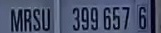

In [287]:
placa = cv2.cvtColor(cv2.imread(str(imgs_path/'placa_original.jpg')), cv2.COLOR_BGR2RGB)
print(ocr(placa))
PIL.Image.fromarray(placa)

## Conversão de imagem colorida para escala de cinza

Para cada pixel da imagem $I(y, x)$ formada pelos canais azul $B(y, x)$, verde $G(y, x)$ e vermelho $R(y, x)$, na convenção do OpenCV $I(y, x) = \left(B(y, x), G(y, x), R(y, x)\right)$ aplicamos uma transformação linear a cada um desses canais para obter um novo canal de cinza $C(y, x)$. Essa transformação é aplicada a cada pixel $(y, x)$ da imagem:

$C(y, x) = 0.114 B(y, x) + 0.587G(y, x) + 0.299R(y, x)$.

Esses coeficientes dependem da sensibilidade do sensor e do meio de exibição (tela) de acordo com a percepção humana. Os coeficientes acimas são para imagens digitais de acordo com a especificação ITU BT.601.

Nota: essa transformação só vale para espaços lineares, quando os valores de cada pixel da imagem não está representada como um resultado de uma exponenciação pelo coeficiente gama $\gamma$: $I_\text{não linear}(y, x) = I(y, x)^\gamma$. Caso a imagem não esteja representada linearmente, é necessário fazer a tranformação inversa dessa exponenciação por gama.

Implemente a sua própria função abaixo que realiza a conversão para escala de cinza $C(y, x) = 0.114 B(y, x) + 0.587G(y, x) + 0.299R(y, x)$, de uma imagem BGR. Não use a função do `cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)`, implemente a sua própria a partir de operações de matrizes com o numpy. (1 ponto)

<details><summary><b>Dica</b></summary>
<p>
Use `matriz.astype(np.float64)` ou  `matriz.astype(np.uint8)` para converter uma matriz numpy para float64 ou uint8 . O numpy aceita operações com matrizes (caso você não queira somar pixel a pixel dentro de um loop), basta você indexar cada canal, por exemplo matrix[:, :, 0].
</p>
</details>

In [288]:
def converte_BGR_para_cinza(imagem_BGR):
    """
    Implemente a sua própria função que converte uma imagem colorida de três canais BGR (blue, green, red) para
    escala de Cinza C conforme a equação C(y, x) = 0.114 B(y, x) + 0.587G(y, x) + 0.299R(y, x) aplicada em cada
    pixel (y, x).
    :param imagem_BGR: Matriz (H, W, 3) que representa a imagem de altura H, largura W e 3 canais de cores BGR
    Retorna uma nova imagem resultante (H, W) em escala de cinza no formato de 8-bits positivos.
    Utilize truncamento para aproximar o resultado intermediário que seria em ponto flutuante (para correção)
    """
    B,G,R = imagem_BGR[:,:,0],imagem_BGR[:,:,1],imagem_BGR[:,:,2]
    imagem_cinza = np.trunc(0.114*B+0.587*G+0.299*R)
    imagem_cinza = imagem_cinza.astype(np.uint8)
    return imagem_cinza

In [289]:
img = np.arange(180, dtype=np.uint8).reshape(6, 10, 3)
assert converte_BGR_para_cinza(img).dtype == np.uint8
assert np.all(converte_BGR_para_cinza(img) == np.array(
      [[  1,   4,   7,  10,  13,  16,  19,  22,  25,  28],
       [ 31,  34,  37,  40,  43,  46,  49,  52,  55,  58],
       [ 61,  64,  67,  70,  73,  76,  79,  82,  85,  88],
       [ 91,  94,  97, 100, 103, 106, 109, 112, 115, 118],
       [121, 124, 127, 130, 133, 136, 139, 142, 145, 148],
       [151, 154, 157, 160, 163, 166, 169, 172, 175, 178]], dtype=np.uint8))

Veja o resultado em um imagem. Apesar da foto abaixo não estar no espaço de cores linear, é uma aproximação:

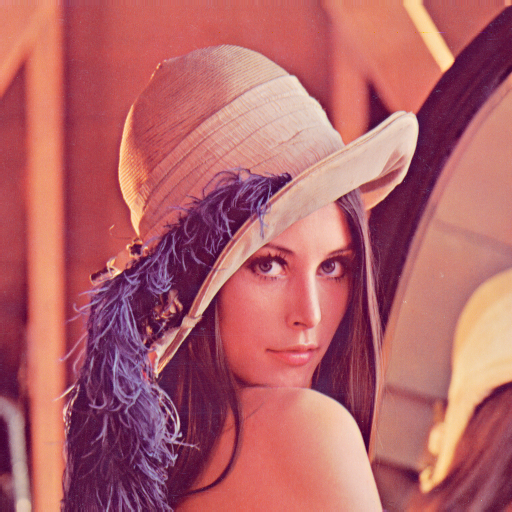

In [290]:
picture = cv2.imread(str(imgs_path/'picture.png'))
PIL.Image.fromarray(cv2.cvtColor(picture, cv2.COLOR_BGR2RGB))

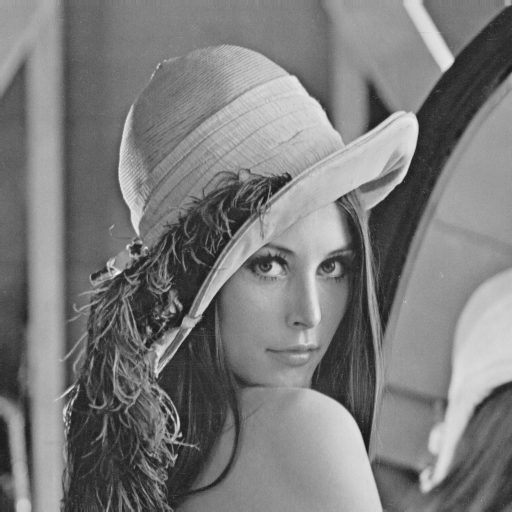

In [291]:
picture_cinza = converte_BGR_para_cinza(picture)
PIL.Image.fromarray(picture_cinza)

## Histograma do valor de cada pixel na imagem

Uma forma interessante de analisar a iluminação é verificar a distribuição dos valores de cada pixel na imagem, isto é, construir um histograma. Geralmente ele é aplicado em cada canal de cores separadamente, ou ainda na imagem em escala de cinza.

Assim para construir um histograma, basta contar quantos pixels tem um determinado valor, que no caso das imagens de 8 bits, são valores que estão entre 0 e 255 (inclusive).

Implemente a função abaixo que retorna a contagem dos valores de cada pixel em uma imagem apenas com um canal de cor. (1 ponto)

<details><summary><b>Dica</b></summary>
<p>
Percorra cada pixel da imagem, contando o seu valor. Outra possibilidade é percorrer cada valor possível e comparar o valor de todos os pixels da imagem com esse valor (parelelamente) usando o `np.sum` para ver quantos resultados retornaram True.
</p>
</details>

In [292]:
def distribuicao(imagem_mono):
    """
    Implemente a sua própria função que realiza a contagem do valor de cada pixel.
    :param imagem_mono: Matriz (H, W) imagem de altura H, largura W
    Retorna um vetor (v) com a contagem (q) dos valores de intensidade luminosa (i) da imagem v[i] = q.
    """
    contagem = np.zeros(256, dtype=np.uint64)
    for i in range(imagem_mono.shape[0]):
      for j in range(imagem_mono.shape[1]):
        k = imagem_mono[i,j]
        contagem[k] += 1
    return contagem

In [293]:
picture = cv2.imread(str(imgs_path/'picture.png'))
canal_verde = picture[:, :, 1]
contagem_histograma = distribuicao(canal_verde)
assert np.all(contagem_histograma ==
      [   0,    0,    0,   11,   65,  111,  164,  261,  308,  431,  537,
        682,  846,  912, 1074, 1350, 1480, 1681, 1621, 2064, 1835, 2048,
       1989, 1911, 2258, 2129, 1748, 1776, 1850, 1687, 1605, 1661, 1355,
       1360, 1189, 1278, 1062, 1027, 1052, 1084, 1013, 1026,  915,  926,
       1029, 1013, 1023,  875, 1110, 1057,  862, 1120,  927, 1073, 1069,
       1004, 1275, 1274, 1129, 1266, 1495, 1548, 1591, 2046, 1706, 1998,
       1704, 2022, 1705, 1800, 1674, 1766, 1593, 1711, 1474, 1491, 1566,
       1456, 1445, 1524, 1371, 1545, 1278, 1606, 1364, 1475, 1513, 1537,
       1813, 1863, 1681, 1885, 2170, 1907, 2008, 1948, 2325, 2094, 1713,
       2084, 1670, 1811, 1720, 1743, 1603, 1693, 1386, 1515, 1639, 1542,
       1588, 1540, 1784, 1751, 1425, 1836, 1604, 1565, 1581, 1507, 1762,
       1769, 1448, 1654, 1872, 1914, 1844, 2103, 1925, 2023, 1811, 2206,
       1907, 1968, 2026, 2096, 2032, 2029, 1730, 1607, 1666, 1454, 1341,
       1354, 1247, 1213,  942, 1152,  931, 1080,  981,  904, 1006, 1003,
        814,  779,  848,  817,  756,  828,  690,  696,  579,  622,  514,
        528,  499,  506,  450,  504,  414,  483,  504,  473,  474,  452,
        621,  587,  512,  611,  652,  723,  645,  656,  850,  777,  720,
        719,  812,  741,  646,  703,  778,  767,  611,  800,  699,  795,
        781,  830,  816,  912,  843,  851,  847,  788,  687,  700,  573,
        499,  377,  388,  288,  294,  241,  201,  168,  167,  125,  114,
        102,  108,   68,   57,   54,   49,   16,   18,   10,    7,    5,
          9,    2,    1,    1,    0,    2,    0,    0,    0,    0,    0,
          1,    0,    0,    2,    0,    0,    1,    0,    0,    0,    0,
          0,    0,    0])

Visualizando essa contagem em um gráfico de barras:

<BarContainer object of 256 artists>

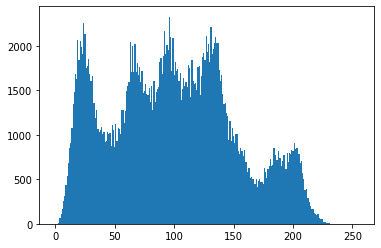

In [294]:
plt.bar(np.arange(256), contagem_histograma, width=1)

O matplotlib também já tem uma função `plt.hist` que já realiza automaticamente o cálculo desse histograma (de um vetor unidirecional). Para isso temos que transformar uma matriz em um vetor que é a concatenação das linhas, como se desenrolássemos a sequência de pixels da matrix `matrix.ravel()` ou `.flatten()`. Só atente para colocar a quantidade de bins entre 0 e 255:

(array([0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 3.000e+00, 1.200e+01, 2.600e+01, 3.600e+01, 8.200e+01,
        1.160e+02, 1.560e+02, 2.040e+02, 2.610e+02, 3.420e+02, 4.650e+02,
        5.620e+02, 6.730e+02, 8.320e+02, 1.017e+03, 1.116e+03, 1.391e+03,
        1.557e+03, 1.718e+03, 1.792e+03, 2.009e+03, 1.995e+03, 2.048e+03,
        2.075e+03, 2.137e+03, 2.012e+03, 2.022e+03, 1.856e+03, 1.779e+03,
        1.714e+03, 1.638e+03, 1.532e+03, 1.367e+03, 1.244e+03, 1.277e+03,
        1.066e+03, 9.790e+02, 9.480e+02, 9.500e+02, 8.500e+02, 8.600e+02,
        7.660e+02, 8.050e+02, 7.840e+02, 7.870e+02, 8.770e+02, 8.030e+02,
        7.670e+02, 8.610e+02, 9.070e+02, 9.060e+02, 8.400e+02, 9.080e+02,
        9.390e+02, 9.520e+02, 9.090e+0

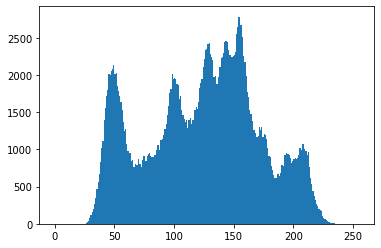

In [295]:
plt.hist(picture_cinza.ravel(), bins=np.arange(256))

## Ganho aditivo e multiplicativo

Para cada pixel $(y, x)$ na imagem de $I$, aplica-se um ganho multiplicativo $\alpha$ e um ganho aditivo $\beta$. Assim, a imagem resultante $I_{r}$ é calculada por $I_{r}(y, x) = \alpha \cdot I(y, x) + \beta$

A função `cv2.convertScaleAbs(image, alpha, beta)` realiza exatamente esse procedimento.

Agora é a sua vez de implementar essa função. (1 ponto)

<details><summary><b>Dica</b></summary>
<p>
Use `matriz.astype(np.float64)` / `np.uint8` para converter uma matriz numpy para float64/uint8 . Use também `np.clip` para limitar o valor mínimo e máximo.
</p>
</details>

In [296]:
def ganho(imagem, multiplicativo, aditivo):
    """
    Implemente a sua própria função de ganho aditivo e multiplicativo (sem usar o cv2.convertScaleAbs), apenas numpy
    Atente para não ocorrer overflow durante as suas operações matemáticas, e que o tipo das imagens é uint8.
    :param imagem: Matriz (H, W) ou (H, W, C) que representa a imagem de altura H, largura W e C canais de cores
    :param multiplicativo: Ganho que deve multiplicar cada pixel da imagem, pode ser um número float.
    :param aditivo: Ganho aditivo que deve ser somado a cada pixel da imagem, pode ser um número float.
    Retorna uma nova imagem resultante da aplicação de um ganho aditivo e multiplicativo, o resultado deve ser
    expresso no formato de imagem 8-bits positivos, dentro dos seus limites de representação (entre 0 e 255).
    Isto é, se o resultado matemático for negativo, deve ser representado como zero, e se maior que 255, 255.
    """
    ad = aditivo*np.ones(imagem.shape)
    imagem_com_ganho = (imagem*multiplicativo+ad).astype(np.uint8)
    imagem_com_ganho = np.clip(imagem_com_ganho, 0, 255)
    return imagem_com_ganho

In [297]:
assert np.all(ganho(np.ones((9, 9), dtype=np.uint8), 30, 50) == 80)
assert ganho(np.ones((9, 9), dtype=np.uint8), 180, 160).dtype == np.uint8

Agora vamos aplicar esse conhecimento de ganho em imagens para conseguir extrair a informação de uma placa cuja foto apresenta baixa luminosidade (na realidade para simular esse efeito apenas apliquei um ganho multiplicativo menor do que 1).

Implemente a função abaixo que seja capaz de recuperar a imagem da placa escura. (1 ponto)

<details><summary><b>Dica</b></summary>
<p>
Veja o histograma da imagem.

Aplique um ganho o suficiente para deixar a cor de fundo mais próxima de branco. Veja os resultados nas células abaixo. Internamente, o Tesseract já realiza a binarização da imagem com um threshold dinâmico (Otsu) que mais preserva a informação, então coloquei uma barra cinza no fundo para enviesar esse limiar.
</p>
</details>

In [298]:
def recupera_imagem_escura(imagem):
    """
    Aplica um ganho aditivo e multiplicativo específicos para a imagem da placa escura.
    :param imagem: Matriz (H, W) ou (H, W, C) que representa a imagem de altura H, largura W e C canais de cores
    Retorna uma imagem recuperada, que seja possível visualizar os caracteres da placa escura (específico).
    """
    imagem_recuperada = ganho(imagem,20,50)
    return imagem_recuperada

In [299]:
placa_escura = cv2.imread(str(imgs_path/'placa_escura.png'))
placa_escura_recuperada = recupera_imagem_escura(placa_escura)
assert ocr(placa_escura_recuperada) == 'APZU 345314 4'

Observe como os caracteres eram pouco visíveis aos olhos humanos na condição de baixa iluminação e como ficaram após essa transformação pixel a pixel.

se ae el Ne es Siar tee Saat ee


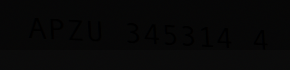

In [300]:
print(ocr(placa_escura))
PIL.Image.fromarray(placa_escura)

APZU 345314 4


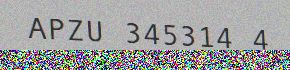

In [301]:
print(ocr(placa_escura_recuperada))
PIL.Image.fromarray(placa_escura_recuperada)

Uma função do OpenCV que também permite equalizar a distribuição de valores de uma imagem é o `cv2.equalizeHist`, que tenta deixar o histograma aproximadamente constante.

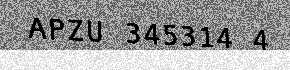

In [302]:
PIL.Image.fromarray(cv2.equalizeHist(placa_escura[:,:,1]))

## Bordas

Muitos algoritmos se atrapalham em regiões de bordas das imagens, sobretudo quando se tenta reconhecer algum padrão ou no nosso caso, placas dos contâiners. Por exemplo, o kernel da convolução não vai conseguir ficar centrado em um elemento tangente aos limites da imagem. Assim, eles acabam desprezando parte dos pixels que estão próximos às bordas, o que significa que letras próximas aos limites da imagem não sejam identificadas corretamente.

Adicionar bordas (padding) a uma imagem (0.5 pontos).

<details><summary><b>Dica</b></summary>
<p>
Use a indexação de vetores/matrizes numpy `matriz[inicio0:fim0, inicio1:fim1, inicio2:fim2]`
</p>
</details>

In [303]:
def adiciona_borda(imagem, cor_borda, espacamentos):
    """
    Adiciona uma borda em uma imagem
    :param imagem: Matriz (H, W, C) que representa a imagem de altura H, largura W e C canais de cores
    :param cor_borda: Tupla (C1, C2, C3, ...) que representa a cor a ser aplicada na borda.
    :param espacamentos: Tupla (esquerda, direita, cima, baixo) que representa a quantidade de pixels a ser
                         adicionada em cada lado da borda.
    Retorna uma imagem com a borda adicionada em cada um dos lados.
    """
    h0, w0, c = imagem.shape
    esquerda, direita, cima, baixo = espacamentos
    imagem_com_borda = np.zeros((h0 + cima + baixo, w0 + esquerda + direita, c), dtype=np.uint8)
    for i in range(imagem_com_borda.shape[0]):
      for j in range(imagem_com_borda.shape[1]):
        if (i<cima or i>=cima+h0) | (j<esquerda or j>=esquerda+w0):
          imagem_com_borda[i,j,:] = cor_borda
        else: imagem_com_borda[i,j,:] = imagem[i-cima,j-esquerda,:]
    #print(imagem_com_borda)
    return imagem_com_borda

In [304]:
img = np.arange(20, dtype=np.uint8).reshape(4, 5, 1)
assert np.all(adiciona_borda(img, (0, ), (2, 2, 1, 1))[:, :, 0] == np.array(
      [[ 0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  1,  2,  3,  4,  0,  0],
       [ 0,  0,  5,  6,  7,  8,  9,  0,  0],
       [ 0,  0, 10, 11, 12, 13, 14,  0,  0],
       [ 0,  0, 15, 16, 17, 18, 19,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0]], dtype=np.uint8))

No exemplo da placa, adicione uma borda na imagem de tal forma que o OCR consiga reconhecer. (0.5 pontos)

In [305]:
def adicionar_borda_placa(imagem):
    """
    Adiciona uma borda à placa para que ela possa ser reconhecida
    :param imagem: Matriz (H, W, 3) que representa a imagem de altura H, largura W e 3 canais de cores
    Retorna uma imagem de uma placa que seja reconhecível pelo OCR.
    """
    imagem_com_borda = adiciona_borda(imagem, (255,255,255), (5, 5, 5, 5))
    return imagem_com_borda

In [306]:
placa_cortada = cv2.imread(str(imgs_path/'placa_cortada.png'))
placa_bordas = adicionar_borda_placa(placa_cortada)
assert ocr(placa_bordas) == 'HLBU 305874 1'

Observe diversos caracteres são identificados corretamente na placa cortada, mas com o padding correto (para livrar as bordas) elas são corretamente identificadas:

In [307]:
print(ocr(placa_cortada))
PIL.Image.fromarray(placa_cortada)

HI BL 3sH5 6/4 st


In [308]:
print(ocr(placa_bordas))
PIL.Image.fromarray(placa_bordas)

HLBU 305874 1


## Convolução

A Convolução é a principal operação que é fundamental para aplicação dos filtros e também para as redes neurais convolucionais. Na realidade, na implementação abaixo, é da operação matemática equivalente a correlação cruzada, uma vez que o kernel não está invertido.

![Correlação Cruzada](https://miro.medium.com/max/526/0*dSjXKGG6kJ5kVUgJ)

Implemente a função de correlação cruzada abaixo. (2 pontos)


<details><summary><b>Dica</b></summary>
<p>
Use a indexação de vetores/matrizes numpy `matriz[inicio0:fim0, inicio1:fim1, inicio2:fim2]`. Use multiplicação elemento a elemento entre matrizes `*`. Use `np.sum` para somar todos os elementos.
</p>
</details>

In [309]:
def convolucao(imagem, filtro):
    """
    Realiza a correlação cruzada de uma imagem em um filtro
    :param imagem: Matriz (H, W) que representa a imagem de altura H, largura W
    :param filtro: Matriz (Hf, Wf) que representa um filtro de altura Hf, largura Wf
    Retorna o resultado da correlação cruzada entre a imagem e o filtro, não precisa se preocupar com normalização
    de norma (o que seria na realidade uma covariância cruzada).
    """
    h0, w0 = imagem.shape
    hf, wf = filtro.shape
    imagem_convolvida = np.zeros((h0 - hf + 1, w0 - wf + 1), dtype=np.float64)
    for y in range(h0 - hf + 1):
        for x in range(w0 - wf + 1):
            imagem_convolvida[y,x] = np.trace(np.matmul(filtro.transpose(),imagem[y:(y+hf),x:(x+wf)]))
    return imagem_convolvida

In [310]:
assert np.all(convolucao(
    np.array([[1, 1, 1, 0, 0],
              [0, 1, 1, 1, 0],
              [0, 0, 1, 1, 1],
              [0, 0, 1, 1, 0],
              [0, 1, 1, 0, 0]]), 
    np.array([[1, 0, 1],
              [0, 1, 0],
              [1, 0, 1]])) == np.array([[4, 3, 4],
                                        [2, 4, 3],
                                        [2, 3, 4]]))

O kernel (filtro) da convolução pode ser um operador matemático que represente uma operação, por exemplo o Filtro de Sobel $\mathbf {G} _{x}={\begin{bmatrix}+1&0&-1\\+2&0&-2\\+1&0&-1\end{bmatrix}}*\mathbf {A}$ que representa a derivada parcial da imagem na direção X (aproximação por diferenças finitas centradas):

[]

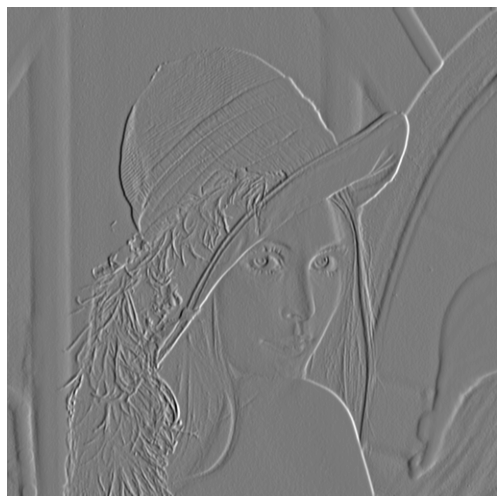

In [311]:
sobel_x = np.array([[1, 0, -1],
                    [2, 0, -2],
                    [1, 0, -1]])
picture_cinza_dx = convolucao(picture_cinza, sobel_x)
plt.figure(figsize=(9,9))
plt.axis(False)
plt.imshow(picture_cinza_dx, cmap='gray')
plt.plot()

## Filtro Gaussiano

Um dos consagrados filtros é o Gaussiano, que é nada mais do que o função de Gauss para o caso bidimensional:

$G(x, y) = \alpha  e^\frac{-(x - x_0)^2 - (y - y_0)^2}{2 \sigma^2}$

A constante $\alpha$ é tal que normaliza a função tal que o somatório dos termos (discretos) sejam igual a 1.

Ele é o melhor filtro clássico para atenuar ruído gaussiano. Também pode ser interpretado um filtro passa-baixa uma vez que atenua as alta frequências (bordas de mudanças bruscas). Se você fizesse a transformada de Fourier (que também é uma função gaussiana) veria que em frequência ele multiplicaria os termos correspondentes às altas frequências, diminuindo-os.


Implemente o kernel gaussiano abaixo de tamanho $(k, k)$, utilizando-se os termos de $x_0 = \frac{k-1}{2}$ e $y_0 = \frac{k-1}{2}$ para que a função fique no centro do kernel. (1 ponto)

In [312]:
def gera_kernel_gaussiano(k, sigma):
    """
    Gera um kernel gaussiano de tamanho k e desvio padrão sigma, implemente você mesmo sem usar o cv2.
    :param k: Tamanho do kernel
    :param sigma: Desvio padrão
    Retorna o kernel gaussiano normalizado, matriz float de tamanho (k, k) tipo float64
    """
    kernel_gaussiano = np.zeros((k, k), dtype=np.float64)
    p0 = (k-1)/2
    for i in range(k):
      for j in range(k):
        kernel_gaussiano[i,j] = np.exp(-((i-p0)**2+(j-p0)**2)/2/(sigma**2))
    alpha = 1/np.sum(kernel_gaussiano)
    kernel_gaussiano=alpha*kernel_gaussiano
    return kernel_gaussiano

In [313]:
assert np.linalg.norm(gera_kernel_gaussiano(3, 1) - np.array(
      [[0.07511361, 0.1238414 , 0.07511361],
       [0.1238414 , 0.20417996, 0.1238414 ],
       [0.07511361, 0.1238414 , 0.07511361]])) < 1e-5

Veja o seu efeito na imagem abaixo:

[]

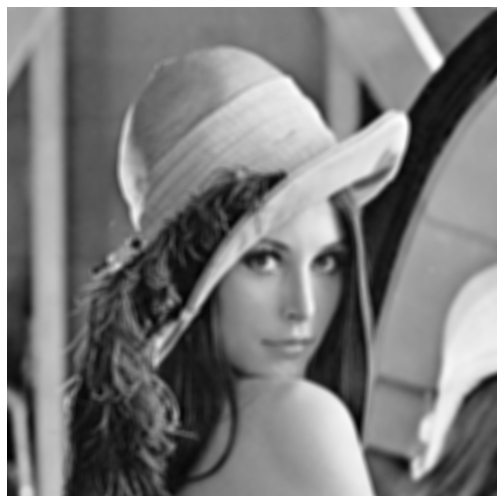

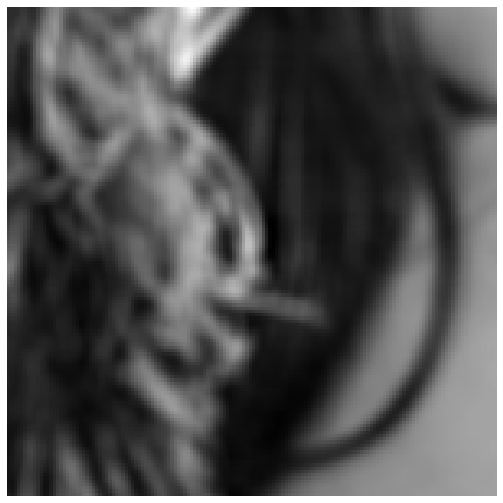

In [314]:
picture_borrada = convolucao(picture_cinza, gera_kernel_gaussiano(7, 5))
plt.figure(figsize=(9,9))
plt.axis(False)
plt.imshow(picture_borrada, cmap='gray')
plt.plot()
plt.figure(figsize=(9,9))
plt.axis(False)
plt.imshow(picture_borrada[350:500, 100:250], cmap='gray', interpolation='nearest')
plt.plot()

Um filtro mais simples seria apenas a média aritmética, mas como ele tem um componente de alta frequência (função sinc gerada do degrau) ele acaba gerando artefatos:

[]

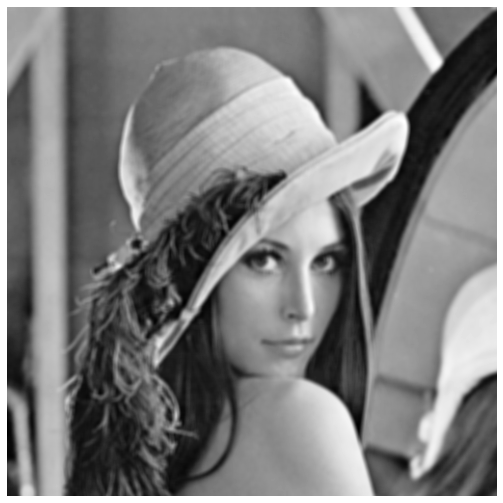

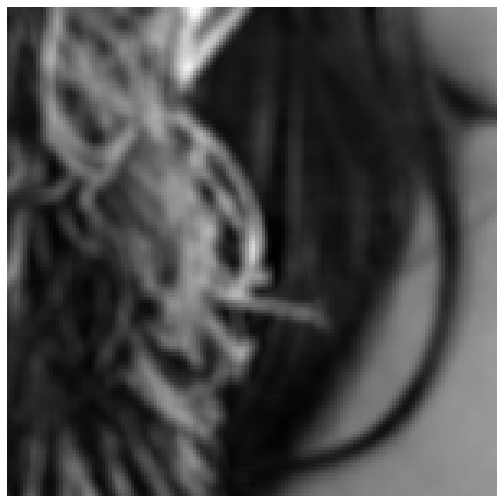

In [315]:
picture_borrada_sinc = convolucao(picture_cinza, np.ones(25).reshape(5,5)/25)
plt.figure(figsize=(9,9))
plt.axis(False)
plt.imshow(picture_borrada_sinc, cmap='gray')
plt.plot()
plt.figure(figsize=(9,9))
plt.axis(False)
plt.imshow(picture_borrada_sinc[350:500, 100:250], cmap='gray', interpolation='nearest')
plt.plot()

Uma consequência interessante é o filtro para desborrar uma imagem. Imagine, se nós conseguimos fazer uma imagem borrada, basta subtraí-la da imagem original para tirar o borrado (unsharpen filter) do inglês.

Observe o código abaixo onde pegamos a imagem original `picture_cinza[3:-3, 3:-3]` (claro que retirando a borda para ficar do mesmo tamanho do resultado da convolução que não tem padding) e subtraíndo da imagem borrada `convolucao(picture_cinza, gera_kernel_gaussiano(7, 5))` (que está escalada de uma constante 0.3). Essas operações separadas era o que faziam com os filmes fotográficos, mas tudo isso é equivalente a um filtro que é 1 menos o gaussiano escalado.

[]

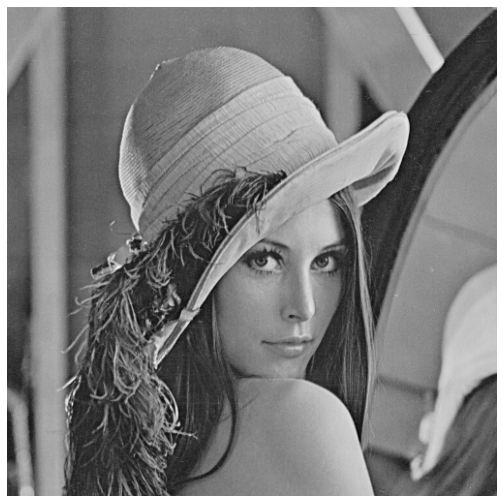

In [316]:
picture_borrada = picture_cinza[3:-3, 3:-3] - convolucao(picture_cinza, gera_kernel_gaussiano(7, 5)) * 0.3
plt.figure(figsize=(9,9))
plt.axis(False)
plt.imshow(picture_borrada, cmap='gray')
plt.plot()

O OpenCv já tem essas funções todas implementadas, ver `cv2.GaussianBlur` para o gaussiano, `cv2.blur` para um filtro constante (média aritmética), `cv2.medianBlur` para uma operação não linear de mediana, `cv2.filter2D` para aplicar um filtro qualquer.

## Ruído

O ruído gaussiano está relacionado sobretudo ao processo de amostragem dos fótons incidentes nos sensores e também a fótons espúrios vindo de radiação do corpo negro.

O filtro clássico que melhor atenua o ruído gaussiano é o filtro gaussiano (tecnicamente na mesma banda de frequência do ruído, aqui simplificado como branco). É como se a cada pixel fosse somado um valor aleatório que veio de uma distribuição gaussiana `np.random.normal`.

Implemente a função abaixo que aplica um filtro gaussiano na imagem da placa até que ela seja reconhecida pelo OCR. (1 ponto)

In [317]:
def filtra_ruido_placa(imagem):
    """
    Aplica um filtro gaussiano na imagem da placa a fim de que o OCR a reconheça. Use a sua função de convolução a 
    partir do seu filtro gaussiano.
    :param imagem: Matriz (H, W) que representa a imagem de altura H, largura W
    Retorna uma imagem filtrada do tipo uint8 que seja reconhecível pelo OCR
    """
    filtro = gera_kernel_gaussiano(6,10)
    imagem_filtrada = convolucao(imagem, filtro)
    imagem_filtrada = imagem_filtrada.astype(np.uint8)
    return imagem_filtrada

In [318]:
placa_ruidosa = converte_BGR_para_cinza(cv2.imread(str(imgs_path/'placa_ruido.png')))
placa_ruidosa_filtrada = filtra_ruido_placa(placa_ruidosa)
assert ocr(placa_ruidosa_filtrada) == 'MEDU 297781 3'


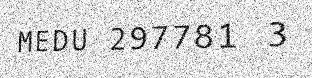

In [319]:
print(ocr(placa_ruidosa))
PIL.Image.fromarray(placa_ruidosa)

MEDU 297781 3


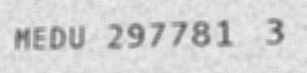

In [320]:
print(ocr(placa_ruidosa_filtrada))
PIL.Image.fromarray(placa_ruidosa_filtrada)

## Operações Morfológicas

A princípio as operações morfológicas lembram a convolução, com a ideia de uma máscara que passa pela imagem. Contudo as operações não são lineares, mas sim escolhem o elemento máximo/mínimo dos selecionados pela máscara se a operação for de dilatação/erosão.

![Dilatação](https://penny-xu.github.io/dialate-d6ec2fc1995eeeb95b917db2c6e1cea0.gif)

A princípio foi pensado para imagens binárias, conforme o exemplo abaixo no qual se aplicou um limiar de 120, mas também pode ser generalizado para escala de cinza (elemento máximo/mínimo da máscara)

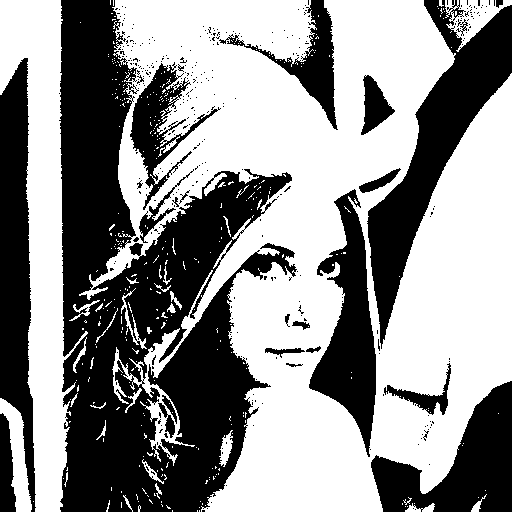

In [321]:
PIL.Image.fromarray(picture_cinza > 120)

In [322]:
def opera_morfologia(imagem):
    """
    Realiza operações morfológicas, pode usar o cv2.dilate/erode/morphologyEx ou cv2.MORPH_CLOSE/MORPH_OPEN
    :param imagem: Matriz (H, W) que representa a imagem de altura H, largura W
    Retorna image após operação morfológica que possibilite a identificação do OCR.
    """
    elemento_estruturante = np.array([[1, 1, 1], # é a máscara que passeia sobre a imagem
                                      [1, 1, 1],
                                      [1, 1, 1]])
    imagem_recuperada = cv2.erode(imagem, elemento_estruturante)
    return imagem_recuperada

In [323]:
placa_erodida = converte_BGR_para_cinza(cv2.imread(str(imgs_path/'placa_erodida.png')))
placa_morf = opera_morfologia(placa_erodida)
assert ocr(placa_morf) == 'APZU 345314 4'

APLU 345314 4


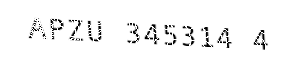

In [324]:
print(ocr(placa_erodida))
PIL.Image.fromarray(placa_erodida)

APZU 345314 4


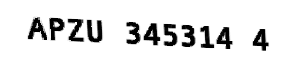

In [325]:
print(ocr(placa_morf))
PIL.Image.fromarray(placa_morf)

Existem diversas outras transformações / processamentos que podem ser realizados em uma imagem. Por exemplo, para rotacionar/escalar/translacionar/torcer em uma transformação afim `cv2.warpAffine`.

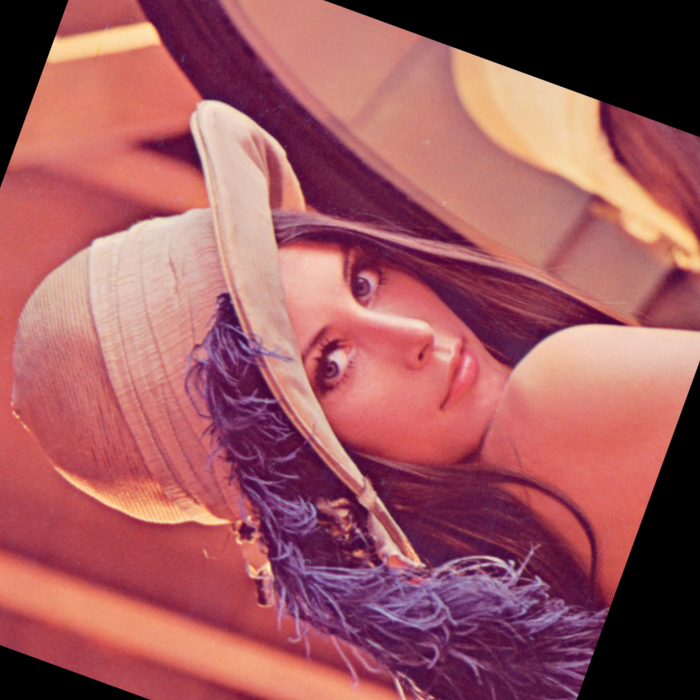

In [326]:
M = cv2.getRotationMatrix2D((350,250), 70, 1.4)
picture_rotacionada = cv2.warpAffine(picture, M, (700, 700))
PIL.Image.fromarray(cv2.cvtColor(picture_rotacionada, cv2.COLOR_BGR2RGB))